In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Inisialisasi SparkSession
spark = SparkSession.builder \
    .appName("Earthquake Prediction") \
    .getOrCreate()

In [ ]:
# Membaca data menggunakan Spark
# Baca file CSV dari HDFS menggunakan Spark
# URL HDFS yang diekspos ngrok
hdfs_url = "hdfs://0.tcp.ap.ngrok.io:13815/user/hdfs/dataset/data_gempa.csv"

# Baca file CSV dari HDFS menggunakan Spark
data = spark.read.csv(hdfs_url, header=True, inferSchema=True)

In [ ]:
# Menampilkan data pertama
data.show(5)

+-----------+--------------------+------------+-----------+-----------+--------+----------+-----------+-----------+--------------------+------+
|   Event ID|           Date time|    Latitude|  Longitude|  Magnitude|Mag Type|Depth (km)|Phase Count|Azimuth Gap|            Location|Agency|
+-----------+--------------------+------------+-----------+-----------+--------+----------+-----------+-----------+--------------------+------+
|bmg2024ccsf|2024-01-30 22:32:...| 1.491829395| 99.6280899|2.887956762|     MLv|       165|         35|118.1091671|Northern Sumatra,...|  BMKG|
|bmg2024cbtb|2024-01-30 09:49:...| 4.366219997|96.84062958| 3.96293717|     MLv|         5|         58|46.14782476|Northern Sumatra,...|  BMKG|
|bmg2024cbcw|2024-01-30 01:38:...|-3.534729958|102.4401474|3.582914497|       M|        10|         38|77.84136963|Southern Sumatra,...|  BMKG|
|bmg2024cbab|2024-01-30 00:13:...|0.2881138921|97.01425171|4.123478001|     MLv|        26|         41|202.6468964|Northern Sumatra,...|

In [ ]:
# Pemrosesan Data (Transformasi Kolom)
from pyspark.sql.functions import col, to_timestamp

# Mengubah kolom 'Date time' menjadi timestamp
data = data.withColumn("timestamp", to_timestamp(col("Date time")))

In [ ]:
# Pilih kolom fitur dan target
X = data.select("Latitude", "Longitude", "Phase Count", "Azimuth Gap", "timestamp")
y = data.select("Magnitude")

In [ ]:
# Membagi data menjadi training dan testing set (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Mengisi missing values dengan nilai default
data = data.fillna({"Latitude": 0, "Longitude": 0, "Magnitude": 0})

In [ ]:
from pyspark.sql.functions import col, to_timestamp, cast
from pyspark.sql.types import DoubleType
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

# Mengubah kolom 'Date time' menjadi timestamp
data = data.withColumn("timestamp", to_timestamp(col("Date time")))

# Cast the timestamp column to DoubleType (seconds since epoch)
data = data.withColumn("timestamp", col("timestamp").cast(DoubleType()))

# Mengisi missing values dengan nilai default (pastikan ini dilakukan setelah transformasi timestamp jika diperlukan)
# data = data.fillna({"Latitude": 0, "Longitude": 0, "Magnitude": 0}) # This line is already in the original notebook, keeping it for completeness

# Membagi data menjadi training dan testing set (80% training, 20% testing)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


# Menyiapkan fitur
assembler = VectorAssembler(inputCols=["Latitude", "Longitude", "Phase Count", "Azimuth Gap", "timestamp"], outputCol="features")

# Membuat model regresi
lr = LinearRegression(featuresCol="features", labelCol="Magnitude")

# Membuat pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Melatih model
model = pipeline.fit(train_data)

# Melakukan prediksi pada data uji
predictions = model.transform(test_data)

# Menampilkan hasil prediksi
predictions.select("Magnitude", "prediction").show(5)

+-----------+------------------+
|  Magnitude|        prediction|
+-----------+------------------+
|3.483218848|3.2009313766025658|
|3.339899754|3.2829966887960973|
|2.944180677|2.9176372063862805|
|4.666972401| 4.540964882766368|
|2.906541577|  3.17453410876612|
+-----------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Menyiapkan RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Magnitude")

# Membuat pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Melatih model
model_rf = pipeline_rf.fit(train_data)

# Melakukan prediksi pada data uji
predictions_rf = model_rf.transform(test_data)

# Menampilkan hasil prediksi
predictions_rf.select("Magnitude", "prediction").show(5)


+-----------+------------------+
|  Magnitude|        prediction|
+-----------+------------------+
|3.483218848|3.6203718596550387|
|3.339899754|3.5408447499414146|
|2.944180677|3.0142199843673554|
|4.666972401| 4.031183095811046|
|2.906541577| 2.824288028159492|
+-----------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Menyiapkan RandomForestRegressor
rf = RandomForestRegressor(featuresCol="features", labelCol="Magnitude")

# Membuat pipeline
pipeline_rf = Pipeline(stages=[assembler, rf])

# Melatih model
model_rf = pipeline_rf.fit(train_data)

# Melakukan prediksi pada data uji
predictions_rf = model_rf.transform(test_data)

# Menampilkan hasil prediksi
predictions_rf.select("Magnitude", "prediction").show(5)


+-----------+------------------+
|  Magnitude|        prediction|
+-----------+------------------+
|3.483218848|3.6203718596550387|
|3.339899754|3.5408447499414146|
|2.944180677|3.0142199843673554|
|4.666972401| 4.031183095811046|
|2.906541577| 2.824288028159492|
+-----------+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluasi model dengan RMSE dan R2
evaluator = RegressionEvaluator(labelCol="Magnitude", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Evaluasi R-squared
evaluator_r2 = RegressionEvaluator(labelCol="Magnitude", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R-squared: {r2}")


Root Mean Squared Error (RMSE): 0.46352994832401967
R-squared: 0.6047395701246974


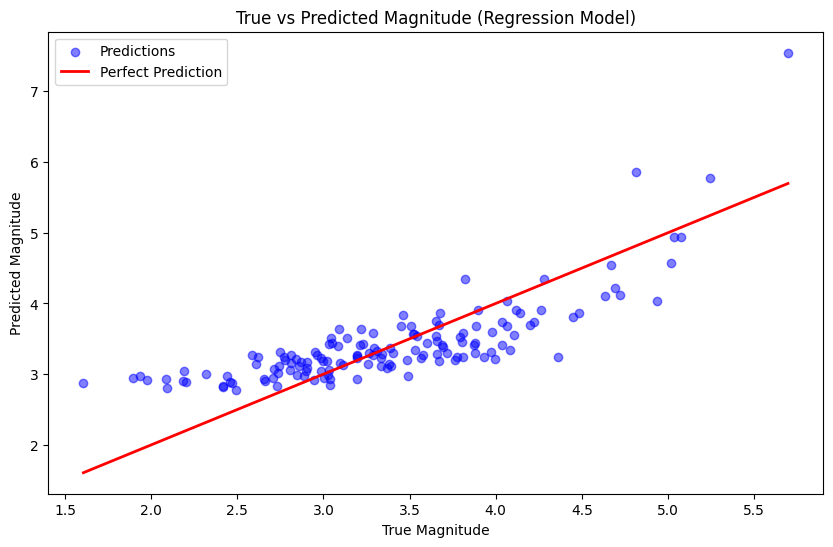

In [ ]:
import matplotlib.pyplot as plt

# Ambil hasil prediksi dan nilai sebenarnya
results = predictions.select("Magnitude", "prediction").toPandas()

# Visualisasikan hasil prediksi vs nilai sebenarnya
plt.figure(figsize=(10, 6))
plt.scatter(results['Magnitude'], results['prediction'], color='blue', alpha=0.5, label='Predictions')
plt.plot([min(results['Magnitude']), max(results['Magnitude'])],
         [min(results['Magnitude']), max(results['Magnitude'])], color='red', linewidth=2, label='Perfect Prediction')
plt.xlabel('True Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('True vs Predicted Magnitude (Regression Model)')
plt.legend()
plt.show()

In [ ]:
# Menyimpan model yang sudah dilatih
model_rf.save("earthquake_rf_model")

In [ ]:
import folium

# Misalnya, kita ambil data hasil prediksi
data_for_map = predictions.select("Latitude", "Longitude", "prediction").toPandas()

# Menyiapkan peta dasar
m = folium.Map(location=[-0.7893, 113.9213], zoom_start=5)

# Menambahkan marker pada peta
for _, row in data_for_map.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=2,  # Ukuran titik
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        popup=f"Predicted Magnitude: {row['prediction']}"
    ).add_to(m)

# Simpan peta ke file HTML
m.save('earthquake_map_spark.html')

In [ ]:
m